# I.) Import libraries

In [1]:
#import libraries
import pandas as pd
import numpy as np
import glob #read multiple files
#display all columns and rows
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import statsmodels.api as sm

# II.) Import data

#### 1. Transformation of Option Data

In [2]:
#import and merge all option data
#last run: 15 min
path = r'/Users/edgarschmidt/Desktop/Masterarbeit/Datasource/Excel_Export/Option_data'
all_files = glob.glob(path + "/*.xlsx")
empty_list = []
for filename in all_files:
    option_data = pd.read_excel(filename, index_col=None, header=0)
    empty_list.append(option_data)
    print("merge",filename)
option_data = pd.concat(empty_list, axis=0, ignore_index=True)

merge /Users/edgarschmidt/Desktop/Masterarbeit/Datasource/Excel_Export/Option_data/delta_hedging_ATM_c_m30_all_2016.xlsx
merge /Users/edgarschmidt/Desktop/Masterarbeit/Datasource/Excel_Export/Option_data/delta_hedging_ATM_c_m30_all_2020.xlsx
merge /Users/edgarschmidt/Desktop/Masterarbeit/Datasource/Excel_Export/Option_data/delta_hedging_ATM_c_m30_all_2017.xlsx
merge /Users/edgarschmidt/Desktop/Masterarbeit/Datasource/Excel_Export/Option_data/delta_hedging_ATM_c_m30_all_2011.xlsx
merge /Users/edgarschmidt/Desktop/Masterarbeit/Datasource/Excel_Export/Option_data/delta_hedging_ATM_c_m30_all_2012.xlsx
merge /Users/edgarschmidt/Desktop/Masterarbeit/Datasource/Excel_Export/Option_data/delta_hedging_ATM_c_m30_all_2013.xlsx
merge /Users/edgarschmidt/Desktop/Masterarbeit/Datasource/Excel_Export/Option_data/delta_hedging_ATM_c_m30_all_2014.xlsx
merge /Users/edgarschmidt/Desktop/Masterarbeit/Datasource/Excel_Export/Option_data/delta_hedging_ATM_c_m30_all_2018.xlsx
merge /Users/edgarschmidt/Deskto

In [3]:
# strike price has to be divided by 1000

option_data['Strike'] = option_data['Strike']/1000
option_data.head(5)

,ID,SecurityID,Datum,Symbol,Strike,Expiration,BestBid,BestOffer,Delta,OptionID,ClosePrice,date_diff,interest_rate,minus30,maturity
0,1,101149,2016-01-04,A 160219C37500,37.5,2016-02-19,3.65,4.00,0.782366,108058735,40.69,1,0.383999,2016-01-20,2016-02-19
1,2,101149,2016-01-05,A 160219C37500,37.5,2016-02-19,3.55,4.30,0.748533,108058735,40.55,1,0.382584,2016-01-20,2016-02-19
2,3,101149,2016-01-06,A 160219C37500,37.5,2016-02-19,3.45,3.95,0.810864,108058735,40.73,1,0.382807,2016-01-20,2016-02-19
3,4,101149,2016-01-07,A 160219C37500,37.5,2016-02-19,2.55,2.87,0.651450,108058735,39.00,1,0.379657,2016-01-20,2016-02-19
4,5,101149,2016-01-08,A 160219C37500,37.5,2016-02-19,2.27,3.25,0.609088,108058735,38.59,3,0.383957,2016-01-20,2016-02-19


In [75]:
# calculation of the option price "C" as middle price between best bid and best offer

option_data['Optionprice_C'] = round(0.5*(option_data['BestBid']+option_data['BestOffer']),2)

In [76]:
# filter option data, so that we have only observations with a maturity of 30 days

print("Shape before transformation: ",option_data.shape)
option_data = option_data[(option_data['Datum'] >= option_data['minus30']) & (option_data['Datum'] <= option_data['maturity'])]
print("Shape after transformation: ",option_data.shape)

Shape before transformation:  (9080229, 16)
Shape after transformation:  (5961046, 16)


In [1]:
# safe copy of the option data
option_data_copy = option_data.copy()

NameError: name 'option_data' is not defined

In [124]:
# missing values for delta are set to -99.xx. 
# we have to delete all options with >= 7 (e.g. x) missing values

def delete_options_with_more_than_x_missings(option_data,x):
    # Identifying the OptionIDs that have more than x missing values
    missing_values = option_data['Delta'] < -99.1
    option_ids_to_remove = option_data.loc[missing_values, 'OptionID'].value_counts()
    option_ids_to_remove = option_ids_to_remove[option_ids_to_remove > x].index.tolist()

    # Removing the identified OptionIDs
    option_data = option_data.loc[~option_data['OptionID'].isin(option_ids_to_remove)]
    
    print("Number of deleted options: ", len(option_ids_to_remove))
    return option_data

In [125]:
option_data_copy = delete_options_with_more_than_x_missings(option_data_copy,6)
print("Shape after transformation: ",option_data_copy.shape)

Number of deleted options:  25549
Shape after transformation:  (5391029, 16)


In [122]:
# replace other missing values with the value of the previous day. If there is no previous day, then use the next day

def replace_missings(option_data):
    #replace the missing values (e.g. the -99,x values) with NaN
    #option_data.loc[option_data['Delta'] < -99,'Delta'] = np.nan <- also good solution
    option_data['Delta'] = np.where(option_data['Delta'] < -99, np.nan, option_data['Delta'])
    
    #for each OptionID replace NaN with the value of the previous day. If there is no previous day, then use the next day
    def fill_missing_values(x):
        return x.fillna(method='ffill').fillna(method='bfill')
    
    option_data['Delta'] = option_data.groupby('OptionID')['Delta'].transform(fill_missing_values)

    return option_data

In [128]:
option_data_copy = replace_missings(option_data_copy)

In [130]:
#count of unique values in each column in tbale option_data
option_data.nunique()

ID               988096
SecurityID         6370
Datum              2421
Symbol           267935
Strike             1642
Expiration          119
BestBid            3963
BestOffer          4040
Delta            979497
OptionID         267985
ClosePrice       111821
date_diff             4
interest_rate      2267
minus30             119
maturity            119
Optionprice_C      5630
dtype: int64

#### 2. Transformation of Stock Data

In [6]:
#import and merge all stock data
path = r'/Users/edgarschmidt/Desktop/Masterarbeit/Datasource/Excel_Export/Stock_data'
all_files = glob.glob(path + "/*.xlsx")
empty_list = []
for filename in all_files:
    stock_data = pd.read_excel(filename, index_col=None, header=0)
    empty_list.append(stock_data)
stock_data = pd.concat(empty_list, axis=0, ignore_index=True)

In [7]:
stock_data.sample(5)

,SecurityID,Datum,ClosePrice,TotalReturn,mkt,SMB,HML,WML
1161648,112282,2013-08-05,135.54,0.001848,-0.0007,0.0048,-0.0015,-0.0013
3153445,105017,2014-01-27,25.44,-0.027895,-0.0065,-0.0084,0.0038,-0.0055
2038803,121222,2011-03-07,8.75,-0.035281,-0.0096,-0.0074,0.0010,-0.0034
1916481,119692,2017-12-28,31.31,-0.011991,0.0022,0.0012,0.0005,-0.0008
1784552,116779,2013-12-11,65.61,-0.034153,-0.0117,-0.0033,0.0006,-0.0048


#### 3. Transformation of Summary Option Data

In [8]:
#import excel file with additional option data
ATM_c_option_m30_all = pd.read_excel('/Users/edgarschmidt/Desktop/Masterarbeit/Datasource/Excel_Export/ATM_c_option_m30_all.xlsx', index_col=None, header=0)

In [9]:
ATM_c_option_m30_all['Strike'] = ATM_c_option_m30_all['Strike']/1000
ATM_c_option_m30_all.head()

,ID,SecurityID,Datum,Symbol,Strike,Expiration,BestBid,BestOffer,LastTradeDate,Volume,OpenInterest,SpecialSettlement,ImpliedVolatility,Delta,ContractSize,ClosePrice
0,1,5139,2019-06-19,CAE 190719C25000,25.0,2019-07-19,1.55,1.80,2019-06-19,3,10,0,0.230397,0.820230,100,26.45
1,2,5139,2019-07-17,CAE 190816C25000,25.0,2019-08-16,2.55,3.40,2019-07-15,0,42,0,0.468454,0.779890,100,27.43
2,3,5139,2019-09-18,CAE 191018C25000,25.0,2019-10-18,0.60,1.35,2019-08-19,0,2,0,0.215069,0.664141,100,25.57
3,4,5139,2019-10-16,CAE 191115C25000,25.0,2019-11-15,0.50,1.00,2019-09-23,0,1,0,0.342190,0.442344,100,24.49
4,5,5139,2019-12-18,CAE 200117C25000,25.0,2020-01-17,1.05,1.90,2019-12-03,0,24,0,0.231454,0.778486,100,26.21


# III.) Calculate Delta-Hedged-Gains

In [137]:
option_data_copy.head(5)

,ID,SecurityID,Datum,Symbol,Strike,Expiration,BestBid,BestOffer,Delta,OptionID,ClosePrice,date_diff,interest_rate,minus30,maturity,Optionprice_C
11,12,101149,2016-01-20,A 160219C37500,37.5,2016-02-19,1.29,1.44,0.495310,108058735,37.26,1,0.382527,2016-01-20,2016-02-19,1.36
12,13,101149,2016-01-21,A 160219C37500,37.5,2016-02-19,1.30,1.37,0.491530,108058735,37.23,1,0.381428,2016-01-20,2016-02-19,1.34
13,14,101149,2016-01-22,A 160219C37500,37.5,2016-02-19,1.51,1.66,0.576211,108058735,37.98,3,0.388625,2016-01-20,2016-02-19,1.58
14,15,101149,2016-01-25,A 160219C37500,37.5,2016-02-19,1.30,1.39,0.532060,108058735,37.61,1,0.381930,2016-01-20,2016-02-19,1.34
15,16,101149,2016-01-26,A 160219C37500,37.5,2016-02-19,1.21,1.32,0.519331,108058735,37.51,1,0.385089,2016-01-20,2016-02-19,1.27


In [140]:
subset = option_data_copy[option_data_copy['OptionID'] == 108058735]

In [162]:
# calculate for every OptionID in option_data the discrete delta hedged gain
# last run: 1 min
def discrete_delta_hedged_gain(subset):
    #select delta value for the earliest date in option_data
    increment_1 = subset[subset['Datum']== max(subset['Datum'])]['Optionprice_C'].values[0] - subset[subset['Datum']== min(subset['Datum'])]['Optionprice_C'].values[0]

    increment_2 = 0 
    for i in range(len(subset)-1):
        increment_2 = increment_2 + subset['Delta'].iloc[i]*(subset['ClosePrice'].iloc[i+1] - subset['ClosePrice'].iloc[i])
    
    increment_3 = 0
    for i in range(len(subset)):
        increment_3 = increment_3 + (1/365)*(subset['date_diff'].iloc[i]*(subset['interest_rate'].iloc[i]/100))*(subset['Optionprice_C'].iloc[i] - subset['Delta'].iloc[i]*subset['ClosePrice'].iloc[i])
    
    return increment_1 - increment_2 - increment_3

In [163]:
discrete_delta_hedged_gain(subset)

-0.5835094513902055

In [166]:
delta_hedged_gains(subset)

,OptionID,SecurityID,Strike,delta_gain,delta_gain_scaled_until_maturity,delta_gain_scaled_after_30_days,days_to_maturity,moneyness
0,108058735,101149,37.5,-0.583908,-0.034317,-0.006791,33,99.36


In [ ]:
def discrete_delta_hedged_gain(option_data):
    """
    Calculate Delta-Hedged-Gain-Return for each OptionID in the dataset.
    Return the result as a new table: "delta_gain_table"
    """
    delta_gain_table = option_data[['OptionID','SecurityID','Strike']].drop_duplicates().reset_index(drop=True)
    delta_gain_table['delta_gain'] = 0
    for i in range(len(delta_gain_table['OptionID'])):
        #filter option_data for each optionID in delta_gain_table 
        option_data_filtered = option_data[option_data['OptionID'] == delta_gain_table['OptionID'][i]].reset_index(drop=True)
        #just to be sure that the data is sorted by date
        option_data_filtered = option_data_filtered.sort_values(by='Datum', ascending=True)
        
        #calculate incremental gains
        increment_1 = option_data_filtered[option_data_filtered['Datum']== max(option_data_filtered['Datum'])]['Optionprice_C'].values[0] - option_data_filtered[option_data_filtered['Datum']== min(option_data_filtered['Datum'])]['Optionprice_C'].values[0]
        increment_2 = 0 
        for j in range(len(option_data_filtered)-1):
            increment_2 = increment_2 + option_data_filtered['Delta'].iloc[j]*(option_data_filtered['ClosePrice'].iloc[j+1] - option_data_filtered['ClosePrice'].iloc[j])
        increment_3 = 0
        for j in range(len(option_data_filtered)):
            increment_3 = increment_3 + (1/365)*(option_data_filtered['date_diff'].iloc[j]*(option_data_filtered['interest_rate'].iloc[j]/100))*(option_data_filtered['Optionprice_C'].iloc[j] - option_data_filtered['Delta'].iloc[j]*option_data_filtered['ClosePrice'].iloc[j])
        
        delta_gain_table['delta_gain'].iloc[i] = increment_1 - increment_2 - increment_3
    return delta_gain_table

In [168]:
def delta_hedged_gains(option_data):
    #get unique optionID and SecurityID
    delta_gain_table = option_data[['OptionID','SecurityID','Strike']].drop_duplicates().reset_index(drop=True)
    delta_gain_table['delta_gain'] = 0
    delta_gain_table['delta_gain_scaled_until_maturity'] = 0
    delta_gain_table['delta_gain_scaled_after_30_days'] = 0
    delta_gain_table['days_to_maturity'] = 0
    delta_gain_table['moneyness'] = 0

    #calculate the delta hedged gains for each optionID
    ## assuming that call price equals "BestOffer" - have to check if this is correct

    for i in range(len(delta_gain_table['OptionID'])):
        #filter option_data for each optionID in delta_gain_table 
        option_data_filtered = option_data[option_data['OptionID'] == delta_gain_table['OptionID'][i]].reset_index(drop=True)
        option_data_filtered = option_data_filtered.sort_values(by='Datum', ascending=True) # just to be sure that the data is sorted by date
        #calculate incremental gains

        x_1_gain_option = option_data_filtered['Optionprice_C'][len(option_data_filtered)-1] - option_data_filtered['Optionprice_C'][0] 
        #print(i+1, "Gain from Option" ,round(x_1_gain_option,6))
        
        x_2_gain_delta_position = 0
        for j in range(len(option_data_filtered)-1): # (!!!) len(option_data_filtered)-1 is that correct?
            x_2_gain_delta_position = x_2_gain_delta_position + option_data_filtered['Delta'][j] * (option_data_filtered['ClosePrice'][j+1] - option_data_filtered['ClosePrice'][j])
        #print(i+1, "Gain from Delta Position" ,round(x_2_gain_delta_position,6))

        x_3_gain_interest = 0
        for j in range(len(option_data_filtered)-1):
            x_3_gain_interest = x_3_gain_interest + option_data_filtered['date_diff'][j] * option_data_filtered['interest_rate'][j]/100 * (1/365) * (option_data_filtered['Optionprice_C'][j] - option_data_filtered['ClosePrice'][j]*option_data_filtered['Delta'][j])
        #print(i+1, "Gain from Interest" ,round(x_3_gain_interest,6))
        
        
        #final delta hedge gain and scaled delta hedge gain for OptionID [i]
        delta_gain_table.iloc[i,3] = x_1_gain_option - x_2_gain_delta_position - x_3_gain_interest
        delta_gain_table.iloc[i,4] = delta_gain_table['delta_gain'][i] / (option_data_filtered.iloc[0,8]*option_data_filtered.iloc[0,10]-option_data_filtered.iloc[0,7]) #[0,10] is the Closeprice at t=0 // scaling with other values (i.e. Closeprice) is also possible // 
        delta_gain_table.iloc[i,6] = delta_gain_table.iloc[i,6] + sum(option_data_filtered['date_diff']) #days to maturity
        delta_gain_table.iloc[i,7] = 100*option_data_filtered.iloc[0,10]/delta_gain_table.iloc[i,2] #moneyness
        #print(i+1, "Delta-Hedged-Gain" ,round(delta_gain_table['delta_gain'][i],6))

        #the table option_data_filtered is now filtered for the next 30 days after the first obersvaterion date (paper calculates until month end)
        #the calculation of the delta hedged gain is the same as above, just for less oberservation days
        #the result is scaled with (DELTA*S-C) (same as in the paper)
        option_data_filtered['Datum'] = pd.to_datetime(option_data_filtered['Datum']) #convert to datetime
        first_date = option_data_filtered['Datum'].min()    #get first date
        last_date = first_date + pd.Timedelta(days=30)      #get last date (first date + 30 days)
        option_data_filtered = option_data_filtered[(option_data_filtered['Datum'] >= first_date) & (option_data_filtered['Datum'] <= last_date)].reset_index(drop=True) #filter for first 30 days

        x_1_gain_option = option_data_filtered['Optionprice_C'][len(option_data_filtered)-1] - option_data_filtered['Optionprice_C'][0] 
        x_2_gain_delta_position = 0
        for j in range(len(option_data_filtered)-1):
            x_2_gain_delta_position = x_2_gain_delta_position + option_data_filtered['Delta'][j] * (option_data_filtered['ClosePrice'][j+1] - option_data_filtered['ClosePrice'][j])
        x_3_gain_interest = 0
        for j in range(len(option_data_filtered)-1):
            x_3_gain_interest = x_3_gain_interest + option_data_filtered['date_diff'][j] * option_data_filtered['interest_rate'][j]/100 * (1/365) * (option_data_filtered['Optionprice_C'][j] - option_data_filtered['ClosePrice'][j]*option_data_filtered['Delta'][j])
            
        delta_gain_table.iloc[i,5] = (x_1_gain_option - x_2_gain_delta_position - x_3_gain_interest) / (option_data_filtered.iloc[0,8]*option_data_filtered.iloc[0,10]-option_data_filtered.iloc[0,7])

    return delta_gain_table

In [172]:
def delta_hedged_gains(option_data):
    # Sort option_data by 'Datum' first to ensure proper date order
    option_data = option_data.sort_values(by='Datum')

    # Group by 'OptionID'
    grouped_option_data = option_data.groupby('OptionID')

    # Define a function to apply to each group
    def calculate_gain(group):
        # Sort by date within the group
        group = group.sort_values(by='Datum')
        
        # Calculations for gains
        x_1_gain_option = group['Optionprice_C'].iloc[-1] - group['Optionprice_C'].iloc[0]
        x_2_gain_delta_position = (group['Delta'].iloc[:-1] * (group['ClosePrice'].diff().iloc[1:])).sum()
        x_3_gain_interest = (group['date_diff'].iloc[:-1] * group['interest_rate'].iloc[:-1] / 100 * (1/365) * (group['Optionprice_C'].iloc[:-1] - group['ClosePrice'].iloc[:-1] * group['Delta'].iloc[:-1])).sum()

        delta_gain = x_1_gain_option - x_2_gain_delta_position - x_3_gain_interest
        delta_gain_scaled_until_maturity = delta_gain / (group.iloc[0,8] * group.iloc[0,10] - group.iloc[0,7])

        return pd.Series({
            'delta_gain': delta_gain,
            'delta_gain_scaled_until_maturity': delta_gain_scaled_until_maturity,
        })

    # Apply the function to each group and concatenate the results
    delta_gain_table = grouped_option_data.apply(calculate_gain).reset_index()

    # Add extra columns from option_data
    extra_columns = option_data[['OptionID','SecurityID','Strike']].drop_duplicates().set_index('OptionID')
    delta_gain_table = delta_gain_table.merge(extra_columns, on='OptionID')

    return delta_gain_table

In [133]:
def summary_statistics_call(option_data):
    analysis = delta_hedged_gains(option_data)
    print("TABLE 1")
    print("")
    print("Summary statistics of options data")
    print("Panel A: Call options (",analysis['OptionID'].nunique(),"observations )")
    summary = round(analysis[['delta_gain_scaled_until_maturity','delta_gain_scaled_after_30_days','days_to_maturity','moneyness']].describe(percentiles=[0.1, 0.25, 0.5, 0.75, 0.9]).transpose(),2)
    return summary

In [12]:
#save top N rows of option_data
N = 100000
option_data_top = option_data.head(N)
option_data_top.head(5)

,ID,SecurityID,Datum,Symbol,Strike,Expiration,BestBid,BestOffer,Delta,OptionID,ClosePrice,date_diff,interest_rate,minus30,maturity
0,1,101149,2016-01-04,A 160219C37500,37.5,2016-02-19,3.65,4.00,0.782366,108058735,40.69,1,0.383999,2016-01-20,2016-02-19
1,2,101149,2016-01-05,A 160219C37500,37.5,2016-02-19,3.55,4.30,0.748533,108058735,40.55,1,0.382584,2016-01-20,2016-02-19
2,3,101149,2016-01-06,A 160219C37500,37.5,2016-02-19,3.45,3.95,0.810864,108058735,40.73,1,0.382807,2016-01-20,2016-02-19
3,4,101149,2016-01-07,A 160219C37500,37.5,2016-02-19,2.55,2.87,0.651450,108058735,39.00,1,0.379657,2016-01-20,2016-02-19
4,5,101149,2016-01-08,A 160219C37500,37.5,2016-02-19,2.27,3.25,0.609088,108058735,38.59,3,0.383957,2016-01-20,2016-02-19


In [134]:
summary_statistics_call(option_data_copy)

TABLE 1

Summary statistics of options data
Panel A: Call options ( 242436 observations )


,count,mean,std,min,10%,25%,50%,75%,90%,max
delta_gain_scaled_until_maturity,242433.0,0.06,0.16,-9.13,-0.04,-0.0,0.03,0.1,0.20,22.19
delta_gain_scaled_after_30_days,242433.0,0.06,0.16,-9.13,-0.04,-0.0,0.03,0.1,0.20,22.19
days_to_maturity,242436.0,33.02,1.21,1.00,33.00,33.0,33.00,33.0,34.00,34.00
moneyness,242436.0,100.15,4.73,53.20,95.71,98.3,99.96,101.6,104.56,168.00


In [167]:
summary_statistics_call(option_data_copy)

TABLE 1

Summary statistics of options data
Panel A: Call options ( 242436 observations )


,count,mean,std,min,10%,25%,50%,75%,90%,max
delta_gain_scaled_until_maturity,242433.0,-0.00,0.09,-4.71,-0.05,-0.02,-0.00,0.02,0.05,10.46
delta_gain_scaled_after_30_days,242433.0,0.06,0.11,-4.65,-0.03,0.00,0.03,0.10,0.19,10.50
days_to_maturity,242436.0,33.02,1.21,1.00,33.00,33.00,33.00,33.00,34.00,34.00
moneyness,242436.0,100.15,4.73,53.20,95.71,98.30,99.96,101.60,104.56,168.00


In [169]:
summary_statistics_call(option_data_copy)

TABLE 1

Summary statistics of options data
Panel A: Call options ( 242436 observations )


,count,mean,std,min,10%,25%,50%,75%,90%,max
delta_gain_scaled_until_maturity,242433.0,-0.00,0.09,-4.71,-0.05,-0.02,-0.00,0.02,0.05,10.46
delta_gain_scaled_after_30_days,242433.0,-0.00,0.09,-4.71,-0.05,-0.02,-0.00,0.02,0.05,10.46
days_to_maturity,242436.0,33.02,1.21,1.00,33.00,33.00,33.00,33.00,34.00,34.00
moneyness,242436.0,100.15,4.73,53.20,95.71,98.30,99.96,101.60,104.56,168.00


In [13]:
summary_statistics_call(option_data)
#last run on whole dataset: 25 min

TABLE 1

Summary statistics of options data
Panel A: Call options ( 268170 observations )


,count,mean,std,min,10%,25%,50%,75%,90%,max
delta_gain_scaled_until_maturity,268170.0,-2.61,869.07,-449291.20,-9.01,-1.37,0.01,0.25,4.47,10293.22
delta_gain_scaled_after_30_days,268170.0,-1.66,806.41,-417269.64,-0.17,-0.02,0.02,0.11,0.25,10283.72
days_to_maturity,268170.0,49.47,3.50,1.00,47.00,48.00,49.00,52.00,53.00,54.00
moneyness,268170.0,100.54,13.12,-100.97,89.00,94.68,99.40,104.56,112.32,662.00


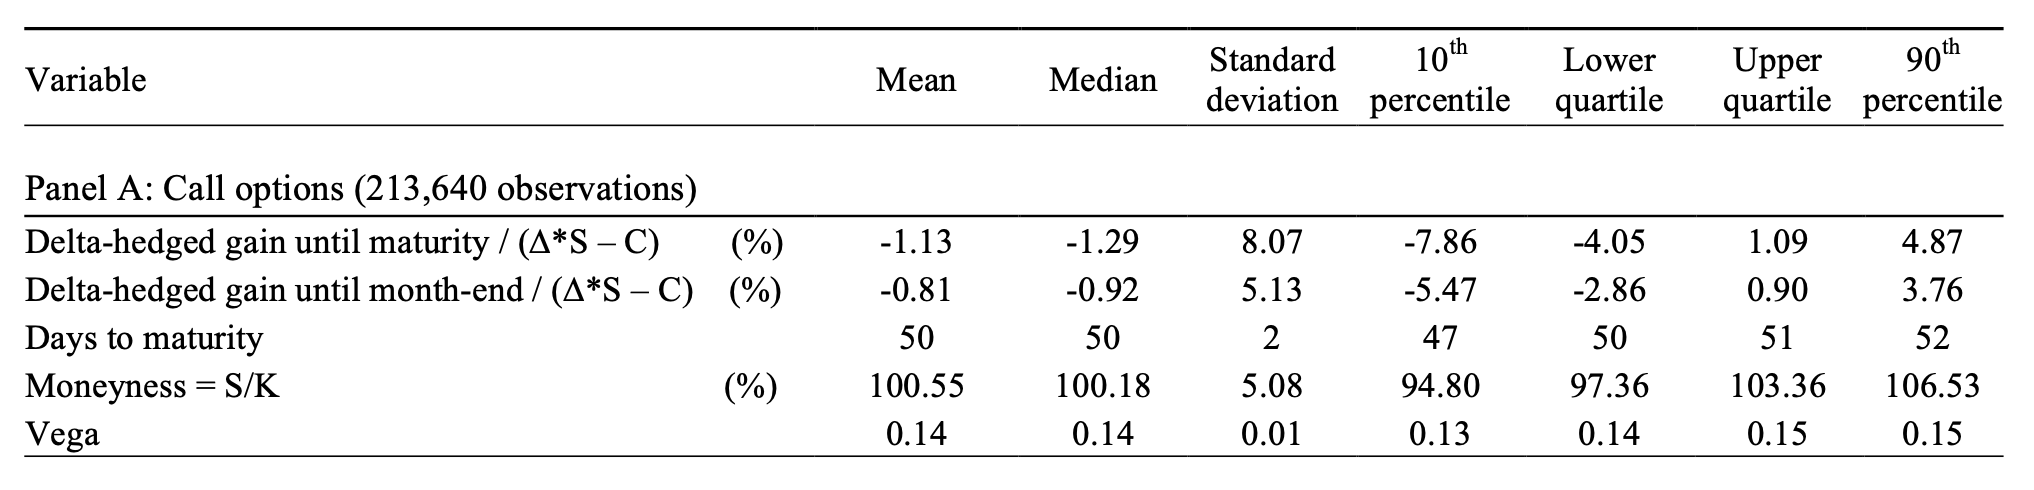

In [14]:
# compare to results from paper
from IPython.display import Image
Image(filename='/Users/edgarschmidt/Desktop/Masterarbeit/Images/Table_1_Panel_A.png')

In [15]:
final_table = delta_hedged_gains(option_data)

In [135]:
option_data_copy[option_data_copy['OptionID'] == 105237776]

,ID,SecurityID,Datum,Symbol,Strike,Expiration,BestBid,BestOffer,Delta,OptionID,ClosePrice,date_diff,interest_rate,minus30,maturity,Optionprice_C


# IV.) Prepare and transform tables: 
###### "stock_returns", "factor_returns" and "volatility_table"

##### <u> Prepare stock return data for Fama-MacBeth-Regression:</u> "stock_returns"

In [23]:
# Prepare stock return data for Fama-MacBeth-Regression

# transform stock_data to a new table with SecurityID as columns and Date as index
print(stock_data.nunique())
print('')

stock_returns = stock_data.pivot(index='Datum', columns='SecurityID', values='TotalReturn')
print('Dimension after transofrmation: ', stock_returns.shape)
# delete columns with NaN values
stock_returns = stock_returns.dropna(axis=1)
print('Dimension after dropping NaN columns: ', stock_returns.shape)
stock_returns.head(5)

SecurityID       2023
Datum            2509
ClosePrice     129857
TotalReturn    186544
mkt               471
SMB               282
HML               288
WML               370
dtype: int64

Dimension after transofrmation:  (2509, 2023)
Dimension after dropping NaN columns:  (2509, 916)


SecurityID,5139,7621,8170,8957,100219,100861,100862,100863,100885,100892,100896,100900,100903,100906,100919,100943,100960,100963,100964,100967,100969,100972,100974,100978,100985,100991,101029,101043,101044,101059,101062,101067,101080,101104,101121,101122,101128,101130,101138,101149,101151,101152,101164,101176,101177,101184,101189,101190,101192,101194,101197,101204,101207,101209,101210,101218,101225,101227,101235,101241,101247,101250,101265,101270,101273,101281,101282,101310,101321,101322,101324,101325,101330,101339,101341,101368,101369,101375,101378,101386,101397,101416,101419,101428,101438,101443,101444,101449,101456,101460,101469,101475,101477,101496,101508,101510,101516,101519,101526,101530,101535,101545,101556,101559,101560,101561,101566,101572,101576,101578,101580,101583,101587,101594,101608,101610,101622,101630,101631,101639,101665,101673,101675,101682,101689,101697,101721,101726,101727,101730,101734,101757,101763,101777,101793,101795,101798,101800,101802,101803,101806,101812,101817,101828,101842,101846,101849,101852,101853,101863,101872,101892,101893,101895,101915,101920,101924,101927,101930,101931,101932,101945,101948,101951,101954,101956,101958,101966,101977,101979,101991,101994,102016,102019,102021,102027,102038,102043,102064,102067,102068,102075,102090,102106,102109,102110,102113,102122,102148,102155,102183,102187,102193,102213,102235,102244,102265,102282,102288,102293,102294,102296,102298,102304,102310,102317,102322,102324,102335,102339,102347,102349,102353,102366,102372,102373,102377,102378,102379,102383,102386,102387,102388,102391,102395,102433,102434,102456,102472,102480,102491,102510,102524,102525,102534,102536,102538,102541,102548,102550,102565,102567,102571,102578,102580,102583,102589,102593,102595,102596,102598,102602,102608,102609,102617,102627,102632,102634,102653,102654,102655,102660,102667,102668,102669,102675,102679,102702,102707,102708,102709,102712,102719,102733,102736,102745,102752,102754,102756,102771,102772,102776,102796,102797,102800,102807,102808,102820,102831,102832,102833,102841,102847,102859,102865,102873,102878,102879,102885,102893,102901,102920,102921,102922,102936,102947,102952,102954,102956,105003,105012,105017,105038,105040,105045,105048,105075,105089,105101,105119,105120,105130,105140,105148,105160,105168,105169,105174,105179,105180,105186,105188,105189,105206,105230,105231,105233,105236,105240,105243,105246,105248,105253,105254,105311,105324,105328,105329,105340,105343,105351,105353,105355,105356,105368,105375,105386,105402,105410,105418,105422,105426,105428,105435,105438,105442,105443,105450,105460,105463,105493,105495,105503,105506,105512,105513,105546,105558,105563,105564,105573,105577,105581,105588,105591,105599,105601,105602,105607,105612,105613,105615,105620,105633,105640,105645,105654,105656,105658,105663,105665,105666,105667,105675,105683,105687,105690,105695,105696,105700,105701,105707,105726,105728,105744,105751,105759,105782,105784,105785,105791,105792,105800,105802,105805,105816,105818,105821,105827,105833,105843,105846,105854,105890,105894,105907,105914,105928,105936,105953,105955,105961,105963,105964,105969,105971,105985,105986,105997,106007,106014,106025,106029,106049,106054,106058,106069,106109,106110,106116,106119,106123,106132,106137,106141,106142,106147,106162,106168,106176,106178,106203,106220,106223,106243,106244,106264,106272,106274,106276,106281,106295,106329,106355,106367,106368,106369,106380,106407,106413,106415,106416,106417,106418,106419,106420,106421,106422,106423,106424,106425,106426,106427,106428,106429,106430,106431,106432,106433,106434,106435,106436,106437,106439,106440,106441,106442,106443,106444,106445,106448,106449,106450,106451,106452,106453,106455,106456,106457,106458,106459,106460,106463,106466,106467,106468,106475,106483,106500,106521,106522,106529,106537,106560,106566,106570,106581,106595,106607,106617,106625,106629,106638,106641,106654,106673,106674,106681,106687,106688,106689,106690,106701,106702,106715,106723,106727,106730,106731,106735,106736,

##### <u> Prepare factor return data for Fama-MacBeth-Regression:</u> "factor_returns"

In [18]:
# transform stock_data to a new table with 'Datum' as index and 'mkt', 'SMB', 'HML' and 'WML' as columns
factor_returns = stock_data[['Datum','mkt','SMB','HML','WML']]
# make 'Datum' to index
factor_returns = factor_returns.set_index('Datum')
print(factor_returns.nunique())
print('')
print('Dimension:', factor_returns.shape)
# delete duplicate rows
factor_returns = factor_returns.drop_duplicates()
print('Dimension after dropping duplicates: ', factor_returns.shape)
factor_returns.head(5)

mkt    471
SMB    282
HML    288
WML    370
dtype: int64

Dimension: (4194300, 4)
Dimension after dropping duplicates:  (2509, 4)


,mkt,SMB,HML,WML
Datum,,,,
2010-01-05,0.0031,-0.0064,0.0124,0.0064
2010-01-06,0.0013,-0.0022,0.0057,-0.0004
2010-01-07,0.0040,0.0009,0.0098,-0.0085
2010-01-08,0.0033,0.0037,0.0001,0.0020
2010-01-11,0.0013,-0.0013,-0.0025,-0.0047


###### Definition of the three factors: 
(Source: http://mba.tuck.dartmouth.edu/pages/faculty/ken.french/Data_Library/f-f_developed.html)

<u>SMB</u>
is the equal-weight average of the returns on the three small stock portfolios for the region minus the average of the returns on the three big stock portfolios,
SMB = 1/3 (Small Value + Small Neutral + Small Growth) – 1/3 (Big Value + Big Neutral + Big Growth)

<u>HML</u>
is the equal-weight average of the returns for the two high B/M portfolios for a region minus the average of the returns for the two low B/M portfolios,
HML = 1/2 (Small Value + Big Value) – 1/2 (Small Growth + Big Growth)

<u>WML</u>
is the equal-weight average of the returns for the two winner portfolios for a region minus the average of the returns for the two loser portfolios,
WML = 1/2 (Small High + Big High) – 1/2 (Small Low + Big Low)

##### <u> Calculate volatility (systematic & idiosyncratic):</u> "volatility_table"

In [1]:
volatility_table = pd.DataFrame(columns=['SecurityID','volatility','systematic_volatility','idiosyncratic_volatility'])
volatility_table['SecurityID'] = stock_returns.columns
volatility_table['volatility'] = 0
volatility_table['idiosyncratic_volatility'] = 0
volatility_table['systematic_volatility'] = 0


for i in range(len(volatility_table['SecurityID'])):
    y = stock_returns.iloc[:,i]
    y = y.reset_index(drop=True)

    X = factor_returns.iloc[:,0]
    X = X.reset_index(drop=True)
    
    X = sm.add_constant(X)
    
    model = sm.OLS(y,X)
    results = model.fit()
    # systematic volatility equals volatility -  (std. res)
    volatility_table.iloc[i,1] = np.std(y)# have to be scaled (Wurzel-T-Gesetz / STD oder Varianz, siehe Paper Cao /Han)
    volatility_table.iloc[i,2] = results.resid.std()
    volatility_table.iloc[i,3] = volatility_table.iloc[i,1] - volatility_table.iloc[i,2]

volatility_table.head(10)

NameError: name 'pd' is not defined

In [ ]:
#backup

volatility_table = pd.DataFrame(columns=['SecurityID','volatility','idiosyncratic_volatility','systematic_volatility'])
volatility_table['SecurityID'] = stock_returns.columns
volatility_table['volatility'] = 0
volatility_table['idiosyncratic_volatility'] = 0
volatility_table['systematic_volatility'] = 0


for i in range(len(volatility_table['SecurityID'])):
    y = stock_returns.iloc[:,i] # stock return
    y = y.reset_index(drop=True)

    X = factor_returns.iloc[:,0] # market return
    X = X.reset_index(drop=True)
    
    X = sm.add_constant(X)
    
    model = sm.OLS(y,X)
    results = model.fit()
    # systematic volatility equals volatility -  (std. res)
    volatility_table.iloc[i,1] = np.var(y) # have to be scaled (Wurzel-T-Gesetz / STD oder Varianz, siehe Paper Cao /Han)
    volatility_table.iloc[i,2] = results.resid.var()
    volatility_table.iloc[i,3] = volatility_table.iloc[i,1] - volatility_table.iloc[i,2]

volatility_table.head(10)

In [28]:
y = stock_returns.iloc[:,0]
y = y.reset_index(drop=True)

X = factor_returns.iloc[:,0]
X = X.reset_index(drop=True)

X = sm.add_constant(X)

model = sm.OLS(y,X)
results = model.fit()

volatility      = round(np.std(y),4)
volatility_sys  = round(results.params[1],4)
volatility_idio = round(results.resid.std(),4)

print('volatility: ', volatility)
print('systematic volatility: ', volatility_sys)
print('idiosyncratic volatility: ', volatility_idio)

volatility:  0.0146
systematic volatility:  0.7311
idiosyncratic volatility:  0.0128


# V.) Fama-MacBeth Regression

#### First stage: time series regressions

In [26]:
betas = []
for asset in stock_returns.columns:
    y = stock_returns[asset].reset_index(drop=True) #risk free rate has to be subtracted from y
    X = factor_returns.reset_index(drop=True)
    X = sm.add_constant(X)

    model = sm.OLS(y, X)
    results = model.fit()

    betas.append(results.params[1:]) #exclude the intercept / constant

betas = pd.DataFrame(betas, index=stock_returns.columns)
betas.head(10)

,mkt,SMB,HML,WML
SecurityID,,,,
5139,0.702004,0.119140,0.139954,-0.063702
7621,0.673094,0.466841,0.785187,0.202248
8170,0.746004,0.895017,-0.046039,-0.297210
8957,1.285248,0.705229,0.384234,-0.496679
100219,0.900337,-0.006771,0.050601,-0.036335
100861,1.025613,1.234135,0.314586,-0.075319
100862,1.043620,1.098214,0.432819,-0.105392
100863,0.784321,1.098421,0.981972,0.058929
100885,0.833942,0.694032,0.284098,0.061945


#### Second stage: cross-sectional regressions

In [27]:
average_excess_returns = stock_returns.mean() # mean of risk free rate has to be subtracted
X = betas
X = sm.add_constant(X)

model = sm.OLS(average_excess_returns, X)
results = model.fit()

# The risk premia are the estimated coefficients (excluding the intercept)
risk_premia = pd.DataFrame(results.params[1:])
risk_premia

,0
mkt,0.001227
SMB,-0.001247
HML,0.000892
WML,0.000446
